# Singular value decomposition for image processing

In [1]:
import os

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from random import sample

from sklearn.datasets import fetch_olivetti_faces
from sklearn.neighbors import KNeighborsClassifier

In [2]:
olivetti_dataset = fetch_olivetti_faces()

## Data
I will be using the CelebA facial dataset. It has identities and attributes of many celebrities. It can be found here:
 https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg

In [3]:
shape = (64, 64)  # Size can be changed, e.g., (96, 84) or (192, 168)
num_identities = 40
images = []
identity_labels = []
test_images = []
test_identity_labels = []
for i in tqdm(sample(range(40),num_identities)):
    
    for j in range(9):
        image = Image.fromarray(olivetti_dataset['images'][10 * i + j])
        image = image.resize(shape[::-1])
        image = np.asarray(image).astype(np.float32)
        images.append(image)
        identity_labels.append(i)
    image = Image.fromarray(olivetti_dataset['images'][10 * i + 9])
    image = image.resize(shape[::-1])
    image = np.asarray(image).astype(np.float32) 
    test_images.append(image)
    test_identity_labels.append(i)
    
images = np.stack(images, axis=0)
test_images = np.stack(test_images, axis = 0)
num_images = images.shape[0]
image_shape = images.shape[1:]
print(f"We have {num_images} of shape {image_shape}.")

  0%|          | 0/40 [00:00<?, ?it/s]

We have 360 of shape (64, 64).


images = images[:351]
images.shape
num_identities = 39

In [4]:
def imshow(image, shape=image_shape, vmin=0, vmax=1, dpi=72, cmap="gray"):
    plt.figure(dpi=dpi)
    plt.axis("off")
    if shape is not None:
        image = np.reshape(image, shape)
    if vmin is None:
        vmin = image.min()
    if vmax is None:
        vmax = image.max()
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)

In [5]:
def imshow_sequence(images, idxs=None, sort=True, title=True, **kwargs):
    if type(idxs) == int:
        idxs = np.random.choice(len(images), idxs)
        if sort:
            idxs.sort()
    elif idxs is None:
        idxs = list(range(len(images)))
    images_show = images[idxs]

    fig, axs = plt.subplots(1, len(images_show), figsize=(20, 20))
    for i in tqdm(range(images_show.shape[0])):
        if title:
            axs[i].title.set_text(f"$i = {idxs[i]}$")
        axs[i].axis("off")
        axs[i].imshow(images_show[i], **kwargs)

  0%|          | 0/9 [00:00<?, ?it/s]

(360, 64, 64)

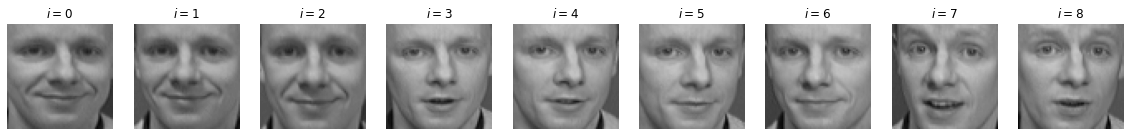

In [6]:
imshow_sequence(images[72:81], vmin=0, vmax=1, cmap="gray")  # A selection of dataset images
images.shape

## Singular value decomposition

In [8]:
D = np.reshape(images, (images.shape[0], -1)).T
print(f"We flatten the images to {D.shape[0]}-dimensional vectors. "
      "They are now column vectors of D.")
D.shape

We flatten the images to 4096-dimensional vectors. They are now column vectors of D.


(4096, 360)

In [27]:
f_bar = np.mean(D, axis=1)[:, None]
D_tilde = D - f_bar  # Mean-center D

The singular value decomposition (SVD) decomposes our dataset $\boldsymbol{D}$ (or more precisely, the mean-centered $\tilde{\boldsymbol{D}}$), into
$$ \boldsymbol{D} = \boldsymbol{U} \boldsymbol{\Sigma} \boldsymbol{V}^T . $$
Particularly, $\boldsymbol{D} \in \mathbb{R}^{d \times n}$, where $d$ is dimensions (i.e., number of pixels) in one image and $n$ is the number of images, so the images are column vectors of $\boldsymbol{D}$. We are primarily interested in $\boldsymbol{U} \in \mathbb{R}^{d \times d}$, as the column vectors of $\boldsymbol{U}$ are the eigenfaces of $\boldsymbol{D}$ in order of decreasing singular values, i.e., importance.

In [28]:
%%time

U, S, VT = linalg.svd(D_tilde)  # Takes ~12s for a (42, 48) image

Wall time: 793 ms


In [29]:
# The column vectors of U is our collection of eigenfaces. We reshape U into U_show so U_show can be
# directly displayed as the eigenfaces.
U_show = np.reshape(U.T, (U.shape[0],) + image_shape)
V = VT.T  # Technically SVD actually outputs V^T, so we transpose it back here

In [30]:
print(f"Results of SVD: U is {U.shape}, S is {S.shape}, and V is {V.shape}")

Results of SVD: U is (4096, 4096), S is (360,), and V is (360, 360)


You can see how the first few eigenfaces, i.e., column vectors of $\boldsymbol{U}$, represents global features of the dataset, e.g., lighting.

  0%|          | 0/8 [00:00<?, ?it/s]

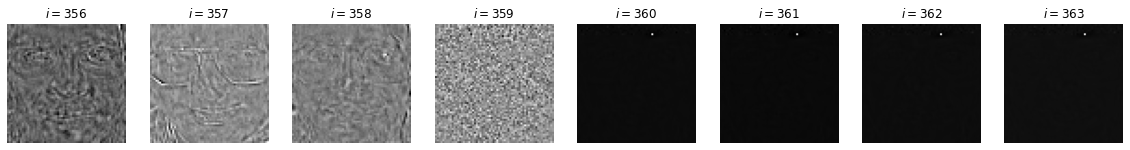

In [31]:
imshow_sequence(U_show, idxs=list(range(356, 364)), cmap="gray")  # The first 8 eigenfaces

You can also see how, as we move from the first eigenfaces (higher singular values) to the last eigenfaces (lower singular values), the eigenfaces begin to represent fine details instead of global features.

  0%|          | 0/12 [00:00<?, ?it/s]

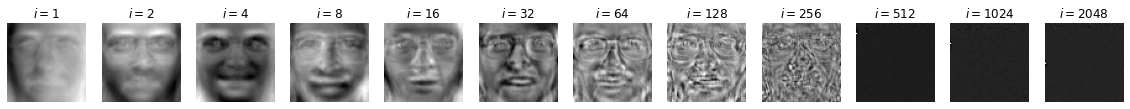

In [32]:
imshow_sequence(U_show, idxs=[pow(2, i) for i in range(12)], cmap="gray")

## Projection & Reconstruction

In [33]:
def extract_from_D(D, i, column=True):
    """Extracts the i^th column vector from D, column=True keeps it as a column vector."""
    if column:
        x = D[:, i:i + 1]
    else:
        x = D[:, i]
    return x

In [34]:
def projection(x, U):
    """Projects x into the column space of U, i.e., write x as linear combination of U."""
    if len(x.shape) == 1:  # Make x a column vector
        x = np.expand_dims(x, axis=1)
    a = (U.T @ x)
    return a

In [35]:
def reconstruction(a, U):
    """Given the coefficients a, reconstruct x with the column vectors of U."""
    if len(a.shape) == 1:  # Make a a column vector
        a = np.expand_dims(a, axis=1)
    x_hat = U @ a
    return x_hat

# Identify Features
There are many different identities (synthetic people) within our dataset. We will average the coefficients of all their images.

In [36]:
identity_coefficients = []
for i in tqdm(range(num_identities)):
    image_array = [projection(extract_from_D(D, j), U) for j in range(9 * i, 9 * (i + 1 ))]
    
    image_array = np.array(image_array).squeeze()
    average_features = np.mean(image_array, axis = 0)
    #imshow(average_features)
    identity_coefficients.append(average_features)
    #identity_coefficients.append(image_array.T @ np.array([1 for i in range(71)]).T)

identity_coefficients = np.array(identity_coefficients)
np.save(f'Coefficients of {num_identities} identites with image size {shape}', identity_coefficients)
    


  0%|          | 0/40 [00:00<?, ?it/s]

In [37]:
def predict_identity(image, a = 25, b = shape[0] * shape[1], epsilon_0 = 0.1):
    mean_centered = image.flatten() - f_bar.squeeze()
    coefficients = projection(mean_centered, U).squeeze()
    identity = None
    epsilon_0 = 0.1
    epsilon_best = np.inf
    for i in range(num_identities):
        A = coefficients[a:b]
        B = identity_coefficients[i][a:b]
        #epsilon_i = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
        epsilon_i = np.linalg.norm(A-B)
        if epsilon_i < epsilon_best:
            epsilon_best = epsilon_i
            identity = i
    #print(epsilon_best)
    return identity

In [41]:
got_correct = []
for i in tqdm(range(num_identities)):
    image = test_images[i]
    predicted_identity = predict_identity(image, a = 25, b = 200) # a =25 best
    got_correct.append(predicted_identity == i)
    #print(f'We predicted {predicted_identity} and it was actually {i}')
    
sum(got_correct) / num_identities

  0%|          | 0/40 [00:00<?, ?it/s]

0.75

# Demo images

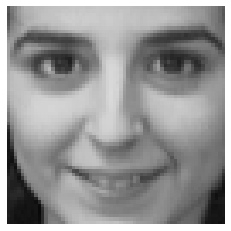

In [20]:
imshow(images[54])

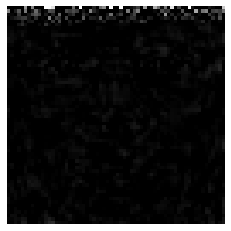

In [21]:
demo_image = extract_from_D(D, 78)
demo_coefficients = projection(demo_image, U)
imshow(demo_coefficients)

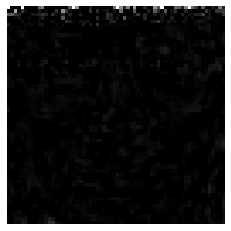

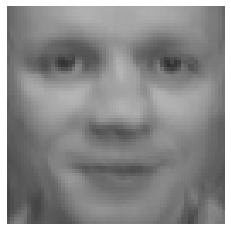

In [868]:
#imshow(reconstructed(identity_coefficients[0], U))
imshow(identity_coefficients[0])
imshow(reconstruction(identity_coefficients[0], U))

# Predicting Using KNN

In [70]:
image_coefficients = U.T @ D_tilde
image_coefficients.T.shape

(360, 4096)

In [119]:
model = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
model.fit(image_coefficients.T, identity_labels)

KNeighborsClassifier(weights='distance')

In [120]:
def predict_identity_KNN(image, a = 20, b = shape[0] * shape[1], epsilon_0 = 0.1):
    mean_centered = image.flatten() - f_bar.squeeze()
    coefficients = projection(mean_centered, U).squeeze()
    coefficients[:a] = 0
    coefficients[b:] = 0
    identity = model.predict([coefficients])
    return identity

In [123]:
got_correct = []
for i in tqdm(range(num_identities)):
    image = test_images[i]
    predicted_identity = predict_identity_KNN(image, a = 0, b = 250) # a =25 best
    got_correct.append(predicted_identity[0] == test_identity_labels[i])
    #print(f'We predicted {predicted_identity[0]} and it was actually {test_identity_labels[i]}')
sum(got_correct) / num_identities

  0%|          | 0/40 [00:00<?, ?it/s]

0.925

In [111]:
D_tilde.T.shape

(360, 4096)

In [112]:
model = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
model.fit(D_tilde.T, identity_labels)

KNeighborsClassifier(weights='distance')